In [14]:
%matplotlib widget

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import json, os
import seaborn as sns   
import pandas as pd
import copy
from ipywidgets import interact, IntSlider, Select, HBox
from utilities import apply_windowing, resize_to_user_resolution
from dicom_tools import DicomToolbox   

In [15]:
data_directory = "/home/ivazquez/Repos/nnUNet/raw_data/neck_cta/anonymized"

dt = DicomToolbox(patient_data_directory = data_directory)

dt.expected_data = ['ct', 'rtstruct']
dt.uniform_slice_thickness = False

all_pat_ids = dt.identify_patient_files()
        
contour = "common carotid lt"       
for p in all_pat_ids:
    dt.parse_dicom_files(p, mask_resolution='ct', mask_names_only=True)
    if contour not in dt.contours:
        print(f"Patient {p} does not have {contour}")

No user inputs were provided. Setting default values.
Multiple slice thicknesses were identified for the CT data of patient 2: 1336.9, 1.25, 1.5 mm
Multiple slice thicknesses were identified for the CT data of patient 3: 0.25, 1.5, 0.5, 1.25, 1.0, 0.75 mm
Multiple slice thicknesses were identified for the CT data of patient 4: 0.2, 1.25, 1.05 mm


Patient 21 does not have common carotid lt


In [ ]:
for p in [pat for pat in all_pat_ids if pat not in ['2' and '21']]: 
    dt.parse_dicom_files(p, mask_resolution='ct', mask_names_only=True)

In [10]:
import numpy as np
all_contours = [dt.parse_dicom_files(pat, mask_resolution='ct', mask_names_only=True) for pat in all_pat_ids]

# Assuming all_contours is a list of contour names
unique_contours, counts = np.unique(all_contours, return_counts=True)

# Printing unique contours and their counts
for contour, count in zip(unique_contours, counts):
    print(f"{contour}, Count: {count}")

aorta, Count: 1
ascending pharyngeal a lt, Count: 29
ascending pharyngeal a rt, Count: 28
buccinator muscle lt, Count: 19
buccinator muscle rt, Count: 19
c spine, Count: 1
celiac, Count: 1
common carotid lt, Count: 29
common carotid rt, Count: 28
common iliac a lt, Count: 1
common iliac a rt, Count: 1
ext carotid a rt, Count: 1
ext carotid lt, Count: 29
ext carotid rt, Count: 28
ext iliac a lt, Count: 1
ext iliac a rt, Count: 1
ext jugular v lt, Count: 1
ext jugular v rt, Count: 1
facial a lt, Count: 29
facial a rt, Count: 29
foramen lacerum lt, Count: 29
foramen lacerum rt, Count: 29
foramen ovale lt, Count: 29
foramen ovale rt, Count: 28
foramen spinosum lt, Count: 29
foramen spinosum rt, Count: 29
forramen ovale rt, Count: 1
hepatic a, Count: 1
int carotid a lt, Count: 1
int carotid a rt, Count: 1
int carotid lt, Count: 28
int carotid rt, Count: 26
int catotid rt, Count: 1
int iliac a lt, Count: 1
int iliac a rt, Count: 1
int jugular v lt, Count: 1
int jugular v rt, Count: 1
ivc, Co

---
# Function to display CT and contours

In [23]:
PAT_ID = 1
DATA_DIRECTORY = "/home/ivazquez/Repos/nnUNet/raw_data/neck_cta/anonymized"
WINDOW_WIDTH = 400 # HU
WINDOW_CENTER = 40 # HU
INITIAL_SLICE = None
COLORMAP = 'gray'

dt = DicomToolbox(patient_data_directory = DATA_DIRECTORY)
dt.expected_data = ['ct', 'rtstruct']
dt.uniform_slice_thickness = False
dt.parse_dicom_files(PAT_ID, mask_resolution = 'ct', mask_names_only=False)

ct = dt.ct.data # grab the ct data
orig_coords = copy.deepcopy(dt.ct.coordinates) # grab the coordinates
# ct, dt.ct.coordinates = resize_to_user_resolution(ct, dt.ct.coordinates, [1,1,1]) 

ct = apply_windowing(ct, WINDOW_WIDTH, WINDOW_CENTER) # apply windowing
structures = [c for c in dt.contours]

# Create a Select widget
select_structures = Select(
    options=structures,
    value=structures[0],
    description='Structures:',
    rows=len(structures))

display(HBox([select_structures]))

No user inputs were provided. Setting default values.


No user inputs were provided. Setting default values.


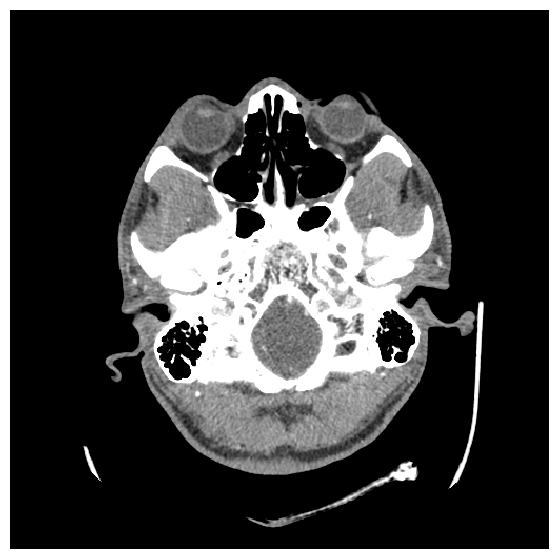

In [4]:
import tkinter as tk
from tkinter import ttk, Listbox, Scrollbar
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import copy
from dicom_tools import DicomToolbox  # Ensure this module is available

class DicomViewer:
    def __init__(self, root, data_directory, pat_id, window_width, window_center):
        self.root = root
        self.data_directory = data_directory
        self.pat_id = pat_id
        self.window_width = window_width
        self.window_center = window_center

        self.dt = DicomToolbox(patient_data_directory=data_directory)
        self.dt.expected_data = ['ct', 'rtstruct']
        self.dt.uniform_slice_thickness = False
        self.dt.parse_dicom_files(pat_id, mask_resolution='ct', mask_names_only=False)

        self.ct = self.dt.ct.data
        self.orig_coords = copy.deepcopy(self.dt.ct.coordinates)
        self.ct = self.apply_windowing(self.ct, window_width, window_center)
        self.structures = [c for c in self.dt.contours]

        self.create_widgets()
        self.update_plot()

    def create_widgets(self):
        self.structure_listbox = Listbox(self.root, selectmode=tk.SINGLE)
        for struct in self.structures:
            self.structure_listbox.insert(tk.END, struct)
        self.structure_listbox.bind('<<ListboxSelect>>', lambda event: self.update_plot())
        self.structure_listbox.pack(side=tk.LEFT, fill=tk.Y)

        scrollbar = Scrollbar(self.root)
        scrollbar.pack(side=tk.LEFT, fill=tk.Y)
        self.structure_listbox.config(yscrollcommand=scrollbar.set)
        scrollbar.config(command=self.structure_listbox.yview)

        self.figure, self.ax = plt.subplots(figsize=(7, 7))
        self.canvas = FigureCanvasTkAgg(self.figure, master=self.root)
        self.canvas.get_tk_widget().pack()

        self.slice_var = tk.IntVar(value=self.ct.shape[0] // 2)
        self.slice_slider = ttk.Scale(self.root, from_=0, to=self.ct.shape[0] - 1, orient="horizontal", variable=self.slice_var)
        self.slice_slider.pack(fill=tk.X)
        self.slice_slider.bind("<Motion>", lambda event: self.update_plot())

        self.root.bind('<Left>', self.previous_slice)
        self.root.bind('<Right>', self.next_slice)

    def apply_windowing(self, image, window_width, window_center):
        min_hu = window_center - window_width // 2
        max_hu = window_center + window_width // 2
        image = np.clip(image, min_hu, max_hu)
        image = (image - min_hu) / (max_hu - min_hu) * 255.0
        return image

    def update_plot(self, event=None):
        slice_idx = self.slice_var.get()
        selected_idx = self.structure_listbox.curselection()
        if selected_idx:
            structure_name = self.structure_listbox.get(selected_idx)
            structure = self.dt.contours[structure_name].data

            self.ax.clear()
            ct_extent = [self.dt.ct.coordinates.x.min(), self.dt.ct.coordinates.x.max(),
                         self.dt.ct.coordinates.y.max(), self.dt.ct.coordinates.y.min()]
            self.ax.imshow(self.ct[slice_idx], cmap='gray', interpolation='none', extent=ct_extent)
            x, y = self.dt.ct.coordinates.x, self.dt.ct.coordinates.y
            self.ax.contour(x, y, structure[slice_idx], levels=[0.5], colors='red')
            self.ax.axis('off')

            self.canvas.draw()

    def previous_slice(self, event):
        current_slice = self.slice_var.get()
        if current_slice > 0:
            self.slice_var.set(current_slice - 1)
            self.update_plot()

    def next_slice(self, event):
        current_slice = self.slice_var.get()
        if current_slice < self.ct.shape[0] - 1:
            self.slice_var.set(current_slice + 1)
            self.update_plot()

if __name__ == "__main__":
    root = tk.Tk()
    root.title("DICOM Viewer")

    data_directory = "/home/ivazquez/Documents/REPOS/nnUNet/raw_data/neck_cta/anonymized"
    pat_id = 1
    window_width = 400
    window_center = 40

    viewer = DicomViewer(root, data_directory, pat_id, window_width, window_center)
    root.mainloop()


In [ ]:
    data_directory = "/home/ivazquez/Documents/REPOS/nnUNet/raw_data/neck_cta/anonymized"


interactive(children=(IntSlider(value=103, description='slice_idx', max=206), Output()), _dom_classes=('widget…

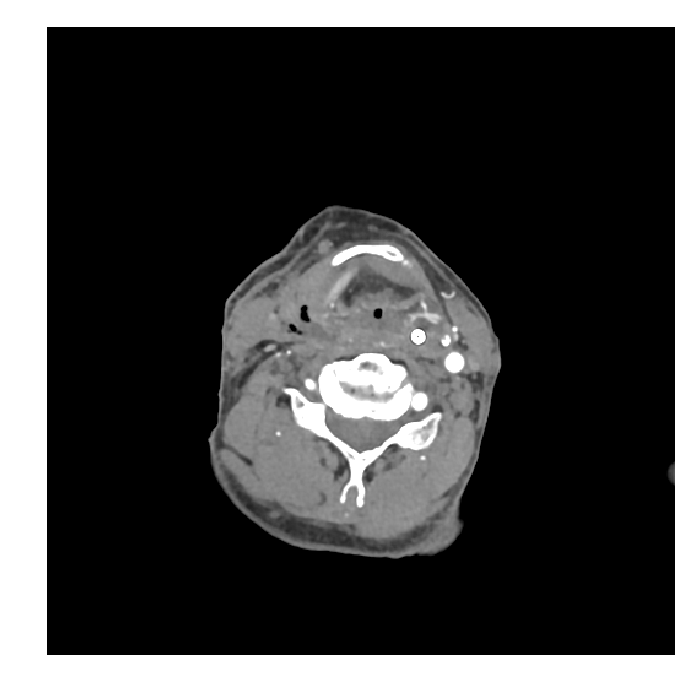

In [25]:
%matplotlib widget

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import json, os
import seaborn as sns   
import pandas as pd
import copy
from ipywidgets import interact, IntSlider, Select, HBox
from utilities import apply_windowing, resize_to_user_resolution
from dicom_tools import DicomToolbox   

PAT_ID = 1
DATA_DIRECTORY = "/home/ivazquez/Repos/nnUNet/raw_data/neck_cta/anonymized"
WINDOW_WIDTH = 400 # HU
WINDOW_CENTER = 40 # HU
INITIAL_SLICE = None
COLORMAP = 'gray'

dt = DicomToolbox(patient_data_directory = DATA_DIRECTORY)
dt.expected_data = ['ct', 'rtstruct']
dt.uniform_slice_thickness = False
dt.parse_dicom_files(PAT_ID, mask_resolution = 'ct', mask_names_only=False)

ct = dt.ct.data # grab the ct data
orig_coords = copy.deepcopy(dt.ct.coordinates) # grab the coordinates
# ct, dt.ct.coordinates = resize_to_user_resolution(ct, dt.ct.coordinates, [1,1,1]) 

ct = apply_windowing(ct, WINDOW_WIDTH, WINDOW_CENTER) # apply windowing
structures = [c for c in dt.contours]

# Create a Select widget
select_structures = Select(
    options=structures,
    value=structures[0],
    description='Structures:',
    rows=len(structures))

display(HBox([select_structures]))

fig, ax = plt.subplots(figsize=(7,7))   
plt.tight_layout()

ct_extent = [dt.ct.coordinates.x.min(), dt.ct.coordinates.x.max(), dt.ct.coordinates.y.max(), dt.ct.coordinates.y.min()]
slice_idx = INITIAL_SLICE if INITIAL_SLICE is not None else ct.shape[0]//2

x, y = dt.ct.coordinates.x, dt.ct.coordinates.y

# Plot initial slice
ct_slice = ax.imshow(ct[slice_idx], cmap='gray', interpolation='none', extent=ct_extent)
structure = dt.contours[select_structures.value].data

# structure,_ = resize_to_user_resolution(structure, orig_coords, [1,1,1]) 

structure_contour = ax.contour(x,y, structure[slice_idx], levels=[0.5], colors='red')
ax.axis('off')

def update(slice_idx):
    global target_contour, structure_contour
    
    ct_slice.set_data(ct[slice_idx])
    ct_slice.set_clim(vmin=np.min(ct[slice_idx]), vmax=np.max(ct[slice_idx]))

    # # Remove previous contour lines for structure
    for coll in structure_contour.collections:
        coll.remove()
 
    structure_contour = ax.contour(x, y, structure[slice_idx], levels=[0.5], colors='red')
 
    plt.draw()

interact(update, slice_idx=IntSlider(min=0, max=ct.shape[0], step=1, value=ct.shape[0]//2));

---

In [ ]:
import nibabel as nib
import numpy as np

# Your NumPy array (replace with your actual data)
array_data = np.random.rand(64, 64, 32)  # Example: 64x64x32 array

# Create a NIfTI1Image object
nifti_image = nib.Nifti1Image(array_data, affine=np.eye(4))

# Save the image to a NIfTI file
nib.save(nifti_image, 'my_nifti_file.nii.gz') 